In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/GAIP_PROJECT/stock_yfinance_data.csv'
all_tweets = pd.read_csv(path)

In [5]:


stock_name = input("Enter stock name - ")
df = all_tweets[all_tweets['Stock Name'] == stock_name]
#dataset = dataset[dataset['Stock Name'] == stock_name]


Enter stock name - NFLX


In [6]:
print(df.shape)
df.head()

(252, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
2016,2021-09-30,608.049988,619.000000,608.049988,610.340027,610.340027,6612600,NFLX
2017,2021-10-01,604.239990,614.989990,597.510010,613.150024,613.150024,4090800,NFLX
2018,2021-10-04,613.390015,626.130005,594.679993,603.349976,603.349976,4995900,NFLX
2019,2021-10-05,606.940002,640.390015,606.890015,634.809998,634.809998,9534300,NFLX
2020,2021-10-06,628.179993,639.869995,626.359985,639.099976,639.099976,4580400,NFLX


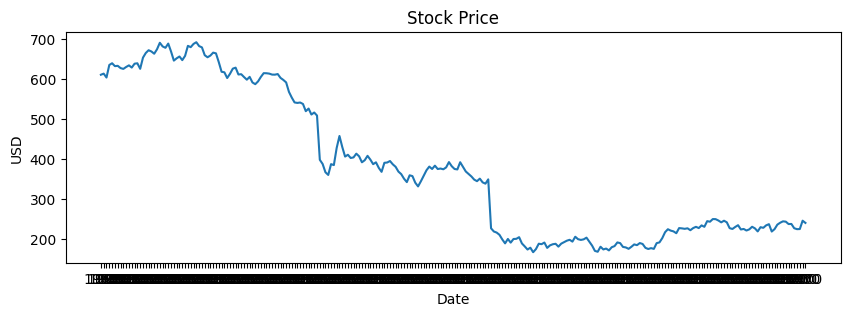

In [7]:
# Create Apple stock price plot
## https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Stock Price')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [8]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

<ipython-input-8-03c50a47f6f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
<ipython-input-8-03c50a47f6f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA21'] = data.iloc[:,4].rolling(window=21).mean()
<ipython-input-8-03c50a47f6f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [9]:
#Drop the first 21 rows
#For doing the fourier
dataset = T_df.iloc[20:,:].reset_index(drop=True)

In [10]:
#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [11]:
#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)


print(Final_data.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2021-10-28  670.950012  676.799988  668.030029  674.049988  674.049988   
1  2021-10-29  673.059998  690.969971  671.239990  690.309998  690.309998   
2  2021-11-01  689.059998  689.969971  676.539978  681.169983  681.169983   
3  2021-11-02  683.109985  687.679993  673.820007  677.719971  677.719971   
4  2021-11-03  677.270020  689.390015  677.270020  688.289978  688.289978   

    Volume Stock Name         MA7        MA21  ...  upper_band  lower_band  \
0  2859400       NFLX  660.032854  638.394755  ...  677.865479  598.924031   
1  3825300       NFLX  669.342852  642.202849  ...  685.595666  598.810032   
2  3110900       NFLX  673.344282  645.441895  ...  687.554409  603.329380   
3  3888600       NFLX  675.192845  648.983323  ...  692.705197  605.261449   
4  2334900       NFLX  677.568560  651.529989  ...  698.179278  604.880699   

          EMA  logmomentum  absolute of 3 comp  angle of 3 comp  \
0

In [12]:
# Final_data.to_csv("/content/drive/MyDrive/GAIP_PROJECT/PROJECT/Finaldata_with_Fourier.csv", index=False)

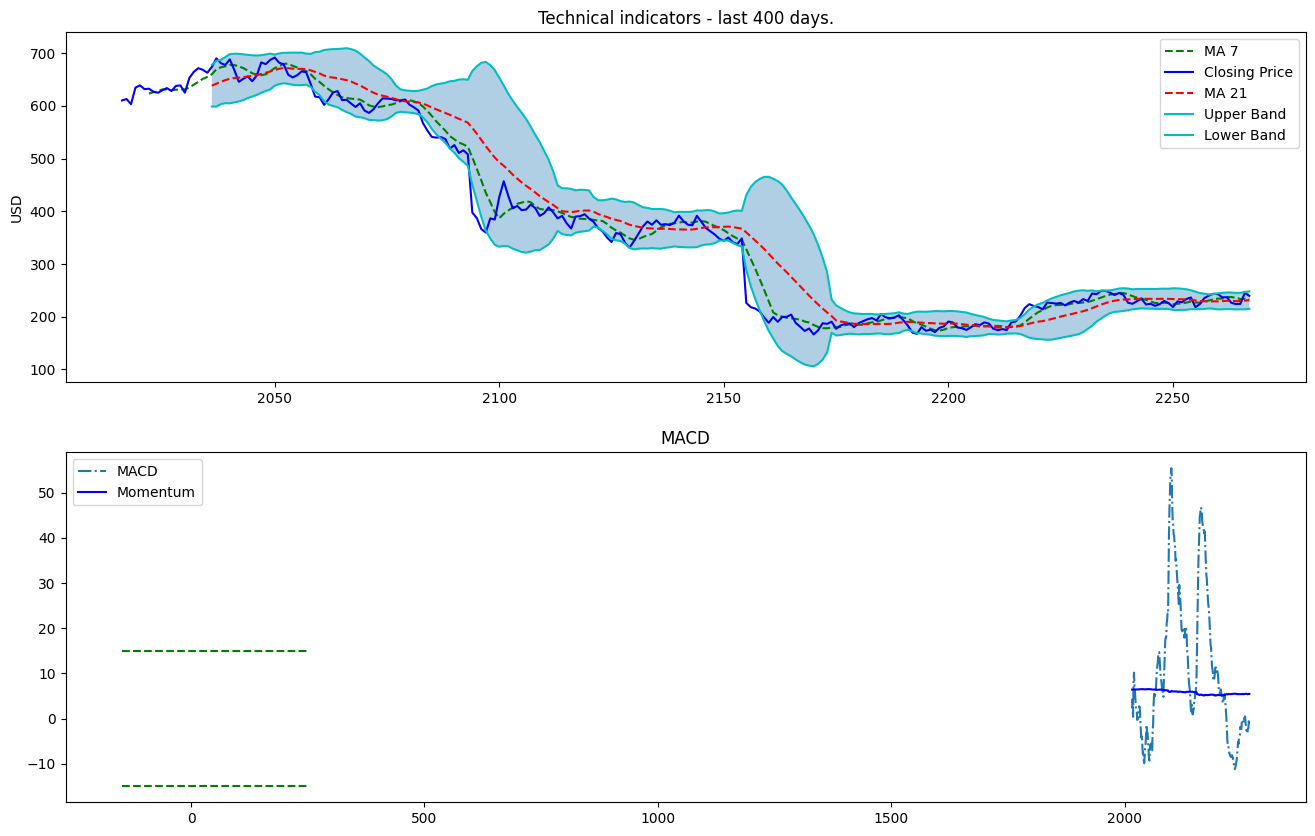

In [13]:
# def plot_technical_indicators(dataset, last_days):
#        plt.figure(figsize=(16, 10), dpi=100)
#        shape_0 = dataset.shape[0]
#        xmacd_ = shape_0 - last_days

#        dataset = dataset.iloc[-last_days:, :]
#        x_ = range(3, dataset.shape[0])
#        x_ = list(dataset.index)

#        # Plot first subplot
#        plt.subplot(2, 1, 1)
#        plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
#        plt.plot(dataset['Close'], label='Closing Price', color='b')
#        plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
#        plt.plot(dataset['upper_band'], label='Upper Band', color='c')
#        plt.plot(dataset['lower_band'], label='Lower Band', color='c')
#        plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
#        plt.title('Technical indicators - last {} days.'.format(last_days))
#        plt.ylabel('USD')
#        plt.legend()

#        # Plot second subplot
#        plt.subplot(2, 1, 2)
#        plt.title('MACD')
#        plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
#        plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#        plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
#        plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')

#        plt.legend()
#        plt.show()

# plot_technical_indicators(T_df, 400)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


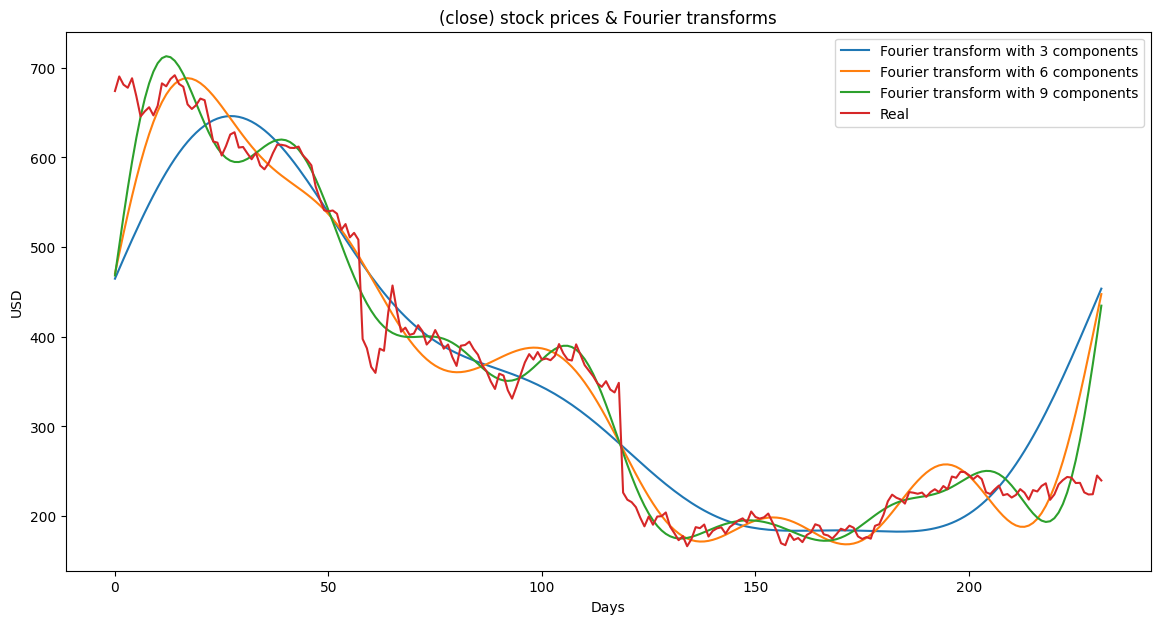

In [14]:
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('(close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(dataset)